In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle
optimization/btest002.pickle
optimization/btest003.pickle
optimization/btest004.pickle
optimization/btest005.pickle
optimization/btest006.pickle
optimization/btest007.pickle
optimization/btest008.pickle
optimization/btest009.pickle
optimization/btest010.pickle
optimization/btest011.pickle
optimization/btest012.pickle
optimization/btest013.pickle
optimization/btest014.pickle
optimization/btest015.pickle
optimization/btest016.pickle
optimization/btest017.pickle


In [2]:
def get_data(test_split=0.25):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, 0, -2, 0]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test], y[ids_test]
    tf_test = X_test[:, 0, -1, 0]
    X_train = X_train[:, :, :-2, :]
    X_test = X_test[:, :, :-2, :]
    
    y_train = np.clip(y_train, -5, 0)
    y_test = np.clip(y_test, -5, 0)
    
    return X_train, X_test, y_train, y_test, profs_test, tf_test

In [3]:
from backtest import DataParser, MovingWindow
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from indicators import ZigZag


def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), False

fsize = 16
tfdict = {"M5":0, "M15":1, "H1":2}
zz = ZigZag()
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        fo = f.Open[:-2]/f.Open[-2]
        fc = f.Close[:-2]/f.Open[:-2]
        fh = f.High[:-2]/f.Open[:-2]
        fl = f.Low[:-2]/f.Open[:-2]
        fv = f.Volume[:-2]/f.Volume[:-2].mean()
        odate = pd.to_datetime(pos.open_date)
        odate = odate.year*10000 + odate.month*100 + odate.day
        if pos.dir > 0:
            x = np.vstack([fc, fo, fl, fh])
        else:
            x = np.vstack([2-fc, 2-fo, 2-fl, 2-fh])
        x = x*100 - 100
        # print(x.flatten())
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.stops_processor.func.cfg.sl/6+1])
        x = np.vstack([x, np.ones(x.shape[1])*btest.cfg.trailing_stop_rate/0.04+1])
        x = np.vstack([x, np.ones(x.shape[1])*odate])
        x = np.vstack([x, np.ones(x.shape[1])*tfdict[btest.cfg.period]])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)

BTCUSD 497
ETHUSD 607
BTCUSD 355
ETHUSD 433
BTCUSD 297
ETHUSD 359
BTCUSD 649
ETHUSD 740
BTCUSD 479
ETHUSD 568
BTCUSD 424
ETHUSD 501
BTCUSD 843
ETHUSD 903
BTCUSD 697
ETHUSD 757
BTCUSD 629
ETHUSD 677
(10379, 1, 8, 16) (10379,)


In [4]:
np.random.seed(2)
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data()
print(X_train.shape, X_test.shape, tf_test.shape)

(7778, 1, 6, 16) (2601, 1, 6, 16) (2601,)


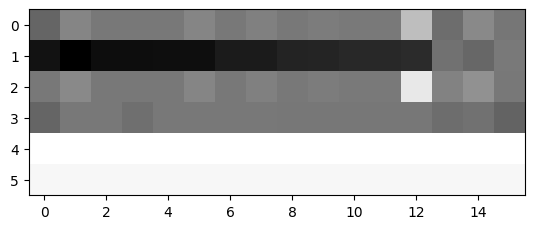

In [5]:
plt.imshow(X_train[0][0][:], cmap="gray")


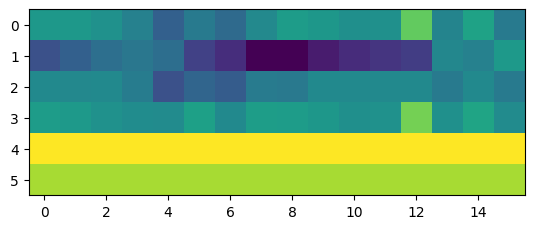

In [6]:
import torch
from torchvision.io import read_image

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.img_labels = y
        self.imgs = X

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label
   
dl_train = CustomImageDataset(X_train, y_train)
plt.imshow(dl_train[-1][0][0])

In [7]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(dl_train, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([128, 1, 6, 16]) torch.Size([128])


In [20]:
import timm
import torch.optim as optim
import torch.nn as nn
# model = timm.create_model('resnet18', in_chans=1, num_classes=1).float().to("mps")

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, (6, 4), padding="same")
        self.conv2 = nn.Conv2d(8, 16, (6, 4), padding="same")
        self.conv3 = nn.Conv2d(16, 32, (6, 4), padding="valid")
        
        self.pool = nn.MaxPool2d((1, 2), (1, 2))
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(32, 1)
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(8)

    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu((self.conv2(x))))
        x = F.relu((self.conv3(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net().to("mps")
# print(summary(model, (1, 6, 16)))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [21]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float().to("mps"))
        loss = criterion(outputs[:, 0], labels.float().to("mps"))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1:03d}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}')
    running_loss = 0.0

[001,    61] loss: 4.574
[002,    61] loss: 4.321
[003,    61] loss: 4.100
[004,    61] loss: 3.888
[005,    61] loss: 3.679
[006,    61] loss: 3.455
[007,    61] loss: 3.209
[008,    61] loss: 2.953
[009,    61] loss: 2.694
[010,    61] loss: 2.453
[011,    61] loss: 2.243
[012,    61] loss: 2.086
[013,    61] loss: 1.977
[014,    61] loss: 1.914
[015,    61] loss: 1.882
[016,    61] loss: 1.869
[017,    61] loss: 1.860
[018,    61] loss: 1.858
[019,    61] loss: 1.856
[020,    61] loss: 1.859
[021,    61] loss: 1.856
[022,    61] loss: 1.854
[023,    61] loss: 1.854
[024,    61] loss: 1.853
[025,    61] loss: 1.853
[026,    61] loss: 1.852
[027,    61] loss: 1.853
[028,    61] loss: 1.853
[029,    61] loss: 1.852
[030,    61] loss: 1.851
[031,    61] loss: 1.851
[032,    61] loss: 1.852
[033,    61] loss: 1.851
[034,    61] loss: 1.850
[035,    61] loss: 1.850
[036,    61] loss: 1.850
[037,    61] loss: 1.850
[038,    61] loss: 1.848
[039,    61] loss: 1.848
[040,    61] loss: 1.848


7778 2601
000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 :+1604.0 -> +1712.4 OK
000 mae_train: 1.12 mae_test: 1.09
[   0.            0.         1603.98852539]  ->  [   0.            0.         1712.40258789]
[      nan       nan 0.0675903]
mae_train: 1.12 mae_test: 1.09 ratio: 0.97
av. profit boost: 0.06759029805004219


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_34064/2172086205.py:32: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


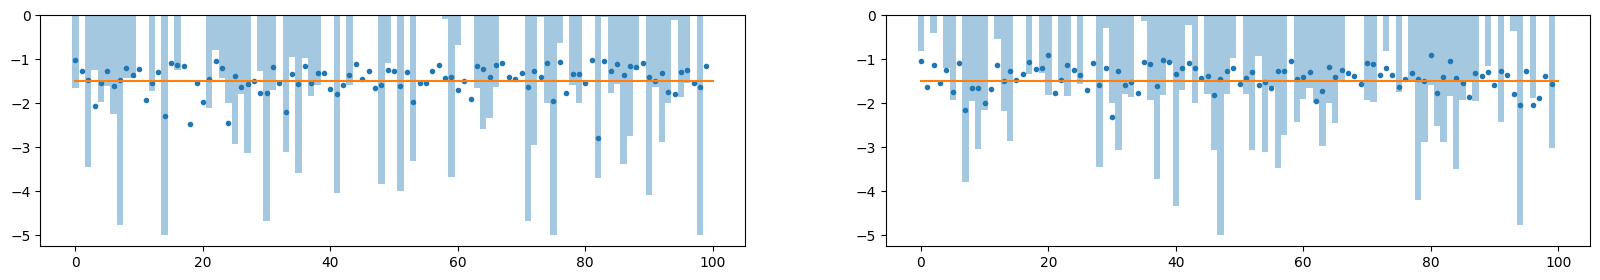

In [26]:
nitrers = 1
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    # X_train, X_test, y_train, y_test, profs_test, tf_test = get_data()
    
    print(X_train.shape[0], X_test.shape[0])

    threshold = -1.5
    if len(X_train):
        # p_train = model.predict(X_train)
        p_train = model(torch.tensor(X_train).float().to("mps")).detach().cpu().numpy().squeeze()
        # threshold = np.percentile(p_train, 10)
        metrics[0, i] = mean_absolute_error(p_train, y_train)
    # p_test = model.predict(X_test)
    p_test = model(torch.tensor(X_test).float().to("mps")).detach().cpu().numpy().squeeze()
    metrics[1, i] = mean_absolute_error(p_test, y_test)

    for j in range(3):
        ids = tf_test == j
        pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
        gprofits[j, i] = profs_test[ids].sum()
        print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f} mae_test: {metrics[1, i]:4.2f}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)
f1_mean = metrics.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
print(f"av. profit boost: {(pprofs_mean[pprofs_mean!=0].mean() - gprofs_mean[gprofs_mean!=0].mean())/abs(gprofs_mean[gprofs_mean!=0].mean())}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
# plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
plt.plot([0, 100], [threshold, threshold])

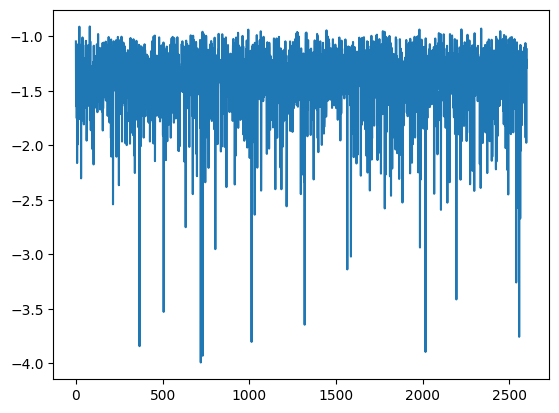

In [25]:
plt.plot(p_test)

000 profit M5 :   +0.0 ->    +0.0 --
000 profit M15:   +0.0 ->    +0.0 --
000 profit H1 : +140.0 ->   +13.0 --
[  0.   0. 140.]  ->  [ 0.  0. 13.]
[        nan         nan -0.90714286]
av. profit boost: -0.9071428571428571


/var/folders/kw/hd5pllps0vs0ln9s5xlr768w0000gn/T/ipykernel_33232/3962858593.py:12: RuntimeWarning: invalid value encountered in divide
  print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))


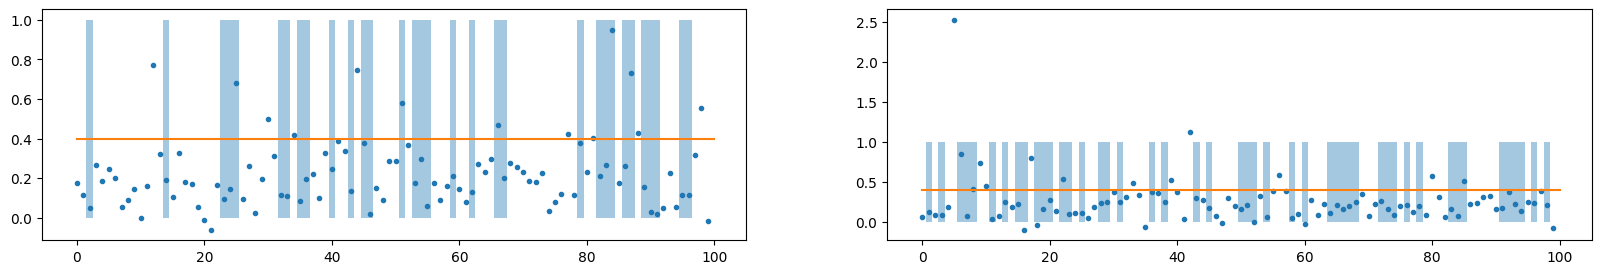

In [14]:
threshold = 0.4
for j in range(3):
    ids = tf_test == j
    pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
    gprofits[j, i] = profs_test[ids].sum()
    print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
    
pprofs_mean = pprofits.mean(1)
gprofs_mean = gprofits.mean(1)

print(gprofs_mean, " -> ", pprofs_mean)
print((pprofs_mean - gprofs_mean)/abs(gprofs_mean))
print(f"av. profit boost: {(pprofits.mean() - gprofits.mean())/gprofits.mean()}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
plt.subplot(1, 2, 2)
plt.plot(p_test[:100], ".")
plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])

In [15]:
set(X_train[:, -1].astype(int)).intersection(set(X_test[:, -1].astype(int)))

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
print(" ".join(map("{:6.4f}".format, model.feature_importances_)))

0.0074 0.0004 0.0014 0.0009 0.0022 0.0258 0.0007 0.0042 0.0000 0.0000 0.0006 0.0051 0.0244 0.0123 0.0029 0.0005 0.0009 0.0000 0.0019 0.0038 0.0001 0.0000 0.0027 0.0003 0.0008 0.0059 0.0047 0.0146 0.0227 0.0058 0.0061 0.0192 0.0102 0.0252 0.0218 0.1189 0.0129 0.0390 0.0000 0.0092 0.0094 0.1496 0.0610 0.0001 0.0300 0.0015 0.0039 0.0096 0.0095 0.0869 0.0426 0.0008 0.0080 0.0287 0.0008 0.0006 0.0173 0.0058 0.0686 0.0197 0.0011 0.0028 0.0016 0.0018 0.0010 0.0024 0.0009 0.0016 0.0014 0.0017 0.0011 0.0079 0.0011 0.0000 0.0024 0.0010 0.0000


In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(1112, 3653, 3682, 3682)

In [ ]:
import mplfinance as mpf

ticker = "GAZP"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="metatrader"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction

array([[0.49287947, 0.50712053]])